# Problem 1

Get familiar with real genetic gate designs by working through the following code.

In [228]:
from urllib.request import urlopen
import json
import numpy as np
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
%matplotlib inline

figsize=(6, 4.5)

## Obtaining model and experimental data

[Cello](https://github.com/CIDARLAB/Cello-v2) is a genetic circuit compiler.
It compiles circuits written in a hardare description language (a sublanguage of `Verilog`) into
  `NOR` and `NOT` gates, to then finally generate DNA with the genetic circuit in it.
Check out the paper by [Nielsen et al.](https://www.science.org/doi/full/10.1126/science.aac7341?casa_token=s0MZasgUtiIAAAAA:hYS8PI5tJ8VqU6daoE-T3BgoOjrA_iXwvzjwFrqeUDiSA3zP5DMc6STWS7mJUZBA8x33QPrCxrvSWw) for a description of the compiler.

We will use modeling and experimental data from the Cello v2 compiler in the form of a [user constraint file (UCF)](https://github.com/CIDARLAB/Cello-UCF/blob/cfb4de1cf125a6fb5af1971730844ea5d0e91623/files/v2/ucf/Eco/Eco1C1G1T1.UCF.json).
Let's load it into a variable so that we can work with it.

In [229]:
def github_to_raw(url: str) -> str:
    """
    Convert a GitHub file URL to its corresponding raw.githubusercontent.com URL.

    Example:
    https://github.com/user/repo/blob/branch/path/to/file
      -> https://raw.githubusercontent.com/user/repo/branch/path/to/file
    """
    if not url.startswith("https://github.com/"):
        raise ValueError("Not a valid GitHub URL")

    parts = url.replace("https://github.com/", "").split("/")
    try:
        user, repo, blob, branch = parts[:4]
        path = "/".join(parts[4:])
    except ValueError:
        raise ValueError("Unexpected GitHub URL format")

    if blob != "blob":
        raise ValueError("URL must contain 'blob' to specify a branch")

    raw_url = f"https://raw.githubusercontent.com/{user}/{repo}/{branch}/{path}"
    return raw_url

# fetch it form this url
# url = "https://github.com/CIDARLAB/Cello-UCF/blob/develop/files/v2/ucf/Eco/Eco1C1G1T1.UCF.json"
url = "https://github.com/CIDARLAB/Cello-UCF/blob/develop/files/v2/ucf/Eco/Eco1C2G2T2.UCF.json"

# get & parse
response = urlopen(github_to_raw(url))
ucf_data = json.loads(response.read())

# if stored locally use this:
#
# with open('Eco1C1G1T1.UCF.json','r') as f:
#     s = f.read()
# ucf_data = json.loads(s)

And check out what is inside. It is a list that starts with a `header` that includes general information from the used bacteria to experimental conditions under which data was obtained:

In [230]:
from pprint import pprint

pprint(ucf_data[0])

{'author': ['Jonghyeon Shin', 'Shuyi Zhang', 'Timothy Jones'],
 'collection': 'header',
 'date': 'Mon Jun 17 14:13:20 EDT 2019',
 'description': 'TetR homologs: PhlF, SrpR, BM3R1, HlyIIR, BetI, AmtR, AmeR, '
                'QacR, IcaRA',
 'genome': 'NEB 10 ∆(ara-leu) 7697 araD139 fhuA ∆lacX74 galK16 galE15 e14- '
           'φ80dlacZ∆M15  recA1 relA1 endA1 nupG  rpsL (StrR) rph spoT1 '
           '∆(mrr-hsdRMS-mcrBC)',
 'growth': 'Inoculation: Individual colonies into M9 media, 16 hours overnight '
           'in plate shaker.  Dilution: Next day, cells dilute ~200-fold into '
           'M9 media with antibiotics, growth for 3 hours.  Induction: Cells '
           'diluted ~650-fold into M9 media with antibiotics.  Growth: shaking '
           'incubator for 5 hours.  Arrest protein production: PBS and 2 mg/ml '
           'kanamycin.  Measurement: flow cytometry, data processing for RPU '
           'normalization.',
 'media': 'M9 minimal media composed of M9 media salts (6.78 g/L N

To get an overview on all the elements stored in the UCF file, let's see the `collection` names for all entries. These describe the type of the item. Since the list is quite long, we compact it into a set to remove multiples.

In [231]:
pprint(set([d['collection'] for d in ucf_data]))

{'circuit_rules',
 'device_rules',
 'functions',
 'gates',
 'genetic_locations',
 'header',
 'logic_constraints',
 'measurement_std',
 'models',
 'motif_library',
 'parts',
 'structures'}


## A NOR gate from the library

The library contains `gates` as can be seen in the `collection` variables.


In [232]:
gates_lib = [d for d in ucf_data if d['collection'] == 'gates']

gate_names = map(lambda x: x["name"], gates_lib[:100])
print(f"There are {len(gates_lib)} gates. in this library. Their names are:")
pprint(list(gate_names))

There are 18 gates. in this library. Their names are:
['P3_PhlF',
 'S2_SrpR',
 'B3_BM3R1',
 'A1_AmtR',
 'H1_HlyIIR',
 'E1_BetI',
 'F2_AmeR',
 'N1_LmrA',
 'B1_BM3R1',
 'B2_BM3R1',
 'P1_PhlF',
 'P2_PhlF',
 'S1_SrpR',
 'S3_SrpR',
 'S4_SrpR',
 'F1_AmeR',
 'C1_CymR',
 'V1_VanR']


Let's pick the first gate in the list and show some info on it.

In [233]:
gate_name = 'A1_AmtR'

# uncomment to try another gate
# gate_name = 'S1_SrpR'

gate = [g for g in gates_lib if g['name'] == gate_name][0]
pprint(gate)

{'collection': 'gates',
 'color': '3BA9E0',
 'gate_type': 'NOR',
 'group': 'AmtR',
 'model': 'A1_AmtR_model',
 'name': 'A1_AmtR',
 'regulator': 'AmtR',
 'structure': 'A1_AmtR_structure',
 'system': 'TetR'}


In fact all gates are `NOR` gates as we can check. This is not too surprising as we discussed in the lecture that `NOR` gates are particularly nice to implement as genetic components.

In [234]:
# check is all gates are NOR
all([g['gate_type'] == 'NOR' for g in gates_lib])

True

## Structure of the gate

It's structure, i.e., the genetic design, is obtained as follows:

In [235]:
structure_lib = [d for d in ucf_data if d['collection'] == 'structures']
print(f"There are {len(structure_lib)} structures in the dataset.\n")

# find matching structure for the chosen gate
structure = [s for s in structure_lib if s['name'] == gate['structure']][0]
pprint(structure)

There are 18 structures in the dataset.

{'collection': 'structures',
 'devices': [{'components': ['#in2', '#in1', 'A1_AmtR_cassette'],
              'name': 'A1_AmtR'},
             {'components': ['BydvJ', 'A1', 'AmtR', 'L3S2P55'],
              'name': 'A1_AmtR_cassette'}],
 'inputs': [{'name': 'in1', 'part_type': 'promoter'},
            {'name': 'in2', 'part_type': 'promoter'}],
 'name': 'A1_AmtR_structure',
 'outputs': ['pAmtR']}


The structure sounds familiar from the lecture: it is a tandem promoter `NOR` gate with two input promoters `in1` and `in2` (see `inputs`). Its output is the `pAmtR` promoter (see `outputs`).

Let's take a look at the components used in this structure to be sure.

In [236]:
parts = ['BydvJ', 'A1', 'AmtR', 'L3S2P55']
parts_lib = [d for d in ucf_data if d['collection'] == 'parts' and d["name"] in parts]
pprint(parts_lib)

[{'collection': 'parts',
  'dnasequence': 'agGGTGTCTCAAGGTGCGTACCTTGACTGATGAGTCCGAAAGGACGAAACACCcctctacaaataattttgtttaa',
  'name': 'BydvJ',
  'type': 'ribozyme'},
 {'collection': 'parts',
  'dnasequence': 'AATGTTCCCTAATAATCAGCAAAGAGGTTACTAG',
  'name': 'A1',
  'type': 'rbs'},
 {'collection': 'parts',
  'dnasequence': 'ATGGCAGGCGCAGTTGGTCGTCCGCGTCGTAGTGCACCGCGTCGTGCAGGTAAAAATCCGCGTGAAGAAATTCTGGATGCAAGCGCAGAACTGTTTACCCGTCAGGGTTTTGCAACCACCAGTACCCATCAGATTGCAGATGCAGTTGGTATTCGTCAGGCAAGCCTGTATTATCATTTTCCGAGCAAAACCGAAATCTTTCTGACCCTGCTGAAAAGCACCGTTGAACCGAGCACCGTTCTGGCAGAAGATCTGAGCACCCTGGATGCAGGTCCGGAAATGCGTCTGTGGGCAATTGTTGCAAGCGAAGTTCGTCTGCTGCTGAGCACCAAATGGAATGTTGGTCGTCTGTATCAGCTGCCGATTGTTGGTAGCGAAGAATTTGCAGAATATCATAGCCAGCGTGAAGCACTGACCAATGTTTTTCGTGATCTGGCAACCGAAATTGTTGGTGATGATCCGCGTGCAGAACTGCCGTTTCATATTACCATGAGCGTTATTGAAATGCGTCGCAATGATGGTAAAATTCCGAGTCCGCTGAGCGCAGATAGCCTGCCGGAAACCGCAATTATGCTGGCAGATGCAAGCCTGGCAGTTCTGGGTGCACCGCTGCCTGCAGATCGTGTTGAAAAAACCCTGGAACTGATTAAACAGGCAGATGCAAAATAA',
  'name

The tandem input promoters drive a construct that comprises of: a [ribozyme](https://en.wikipedia.org/wiki/Ribozyme), an RBS, a CDS for the repressor AmtR, and a terminator.

Somewhere, and not necessarily after this first construct, is the output promoter `pAmtR` that is repressed by AmtR. This promoter can be an input of another gate, or be directly driving a reporter gene, e.g., a CDS that expresses [GFP](https://en.wikipedia.org/wiki/Green_fluorescent_protein).

## Model of the gate

We can also obtain a model for the gate from the library.

In [237]:
model_lib = [d for d in ucf_data if d['collection'] == 'models']
model = [m for m in model_lib if m['name'] == gate['model']][0]
pprint(model)

{'collection': 'models',
 'functions': {'cytometry': 'A1_AmtR_cytometry',
               'input_composition': 'tandem_input_composition',
               'response_function': 'Hill_response',
               'tandem_interference_factor': 'tandem_interference_factor',
               'toxicity': 'A1_AmtR_toxicity'},
 'name': 'A1_AmtR_model',
 'parameters': [{'description': 'Maximal transcription',
                 'name': 'ymax',
                 'value': 3.13661101},
                {'description': 'Minimal transcription',
                 'name': 'ymin',
                 'value': 0.035221608},
                {'description': 'Half-maximum',
                 'name': 'K',
                 'value': 0.047427884},
                {'description': 'Cooperativety',
                 'name': 'n',
                 'value': 1.656171138},
                {'description': 'Tandem factor',
                 'name': 'alpha',
                 'value': 0.274797631},
                {'description': 'Tandem f

It says that a Hill `response_function` is used as a model with the additional specification that the inputs are composed via a `tandem_input_composition`. We will check this out by looking into the collection of `functions`. Indeed the first entries are what we where looking for. The next (third) entry looks like experimental data, and we will come back to it later.

In [238]:
functions_lib = [d for d in ucf_data if d['collection'] == 'functions']

print('The first two elements describe these theoretical models:\n')
pprint(functions_lib[0])
print()
pprint(functions_lib[1])
print()
pprint(functions_lib[2])

The first two elements describe these theoretical models:

{'collection': 'functions',
 'equation': 'ymin + (ymax - ymin) / (1.0 + (x / K)^n)',
 'name': 'Hill_response',
 'parameters': [{'map': '#//model/parameters/ymax', 'name': 'ymax'},
                {'map': '#//model/parameters/ymin', 'name': 'ymin'},
                {'map': '#//model/parameters/K', 'name': 'K'},
                {'map': '#//model/parameters/n', 'name': 'n'}],
 'variables': [{'map': '#//model/functions/input_composition', 'name': 'x'}]}

{'collection': 'functions',
 'equation': 't1 * x2 + x1',
 'name': 'tandem_input_composition',
 'variables': [{'map': '#//structure/inputs/in1/model/functions/response_function',
                'name': 'x1'},
               {'map': '#//structure/inputs/in2/model/functions/response_function',
                'name': 'x2'},
               {'map': '#//structure/inputs/in1/model/functions/tandem_interference_factor',
                'name': 't1'}]}

{'collection': 'functions',
 'equati

Again the functions are familiar from the lecture.

## Transfer Characteristics of the Gate

ymax: 3.13661101
ymin: 0.035221608
K: 0.047427884
n: 1.656171138
alpha: 0.274797631
beta: 1.0
tau_on: 0.9
tau_off: 2.5


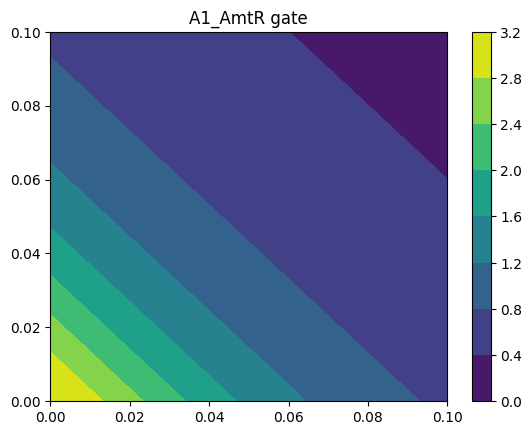

In [239]:
params = {}
for p in model['parameters']:
    params[p['name']] = np.float64(p['value'])
    print(f"{p['name']}: {p['value']}")

def inv(x):
    return params['ymin'] + (params['ymax'] - params['ymin']) / (1.0 + (x / params['K'])**params['n'])

def nor(x, y):
    inputs = x + y  # linear input combination
    return inv(inputs)

def contour_fun(x, y, z, title=None):
    """
    Make a filled contour plot given x, y, z
    in 2D arrays.
    """
    plt.figure()
    CS = plt.contourf(x, y, z)
    cbar = plt.colorbar(CS)
    if title is not None:
        plt.title(title)

def contour_fun(x, y, z, title=None):
    """
    Make a filled contour plot given x, y, z
    in 2D arrays.
    """
    plt.figure()
    CS = plt.contourf(x, y, z)
    cbar = plt.colorbar(CS)
    if title is not None:
        plt.title(title)

# Get x and y values for plotting
x = np.linspace(0, 0.1, 200)
y = np.linspace(0, 0.1, 200)
xx, yy = np.meshgrid(x, y)

# plot it
contour_fun(
    xx, yy,
    nor(xx, yy),
    title=f"{gate_name} gate"
)

## Measurements

Intrestingly there are even measurments that give much greater detail.
Remember that the steady state input-output behavior is **deterministic** with Hill functions.
In fact, measurments show that there is **significant noise** on output behavior.

To see this, let's look at measurements:
The measurements are (normalized) histograms of steady-state input-output measurements in terms of **Relative Promotor Units (RPUs)**.
Details are described in the [supplementary material of Nielsen et al.](https://www.science.org/doi/suppl/10.1126/science.aac7341/suppl_file/nielsen.sm.pdf).
For example, Figure S30 shows how distributions are probagated and Section VII.C.9. “gate_cytometry” states that RPUs in UCFs are measured on the same RPU scale to allow for propagation between gates.

Let's plot the response distribution for 3 inputs to such a component and to be sure check if it is already normalized to be a distribution.

In [240]:
pprint([f["name"] for f in functions_lib])

['Hill_response',
 'tandem_input_composition',
 'tandem_interference_factor',
 'P3_PhlF_toxicity',
 'S2_SrpR_toxicity',
 'B3_BM3R1_toxicity',
 'A1_AmtR_toxicity',
 'H1_HlyIIR_toxicity',
 'E1_BetI_toxicity',
 'F2_AmeR_toxicity',
 'N1_LmrA_toxicity',
 'B1_BM3R1_toxicity',
 'B2_BM3R1_toxicity',
 'P1_PhlF_toxicity',
 'P2_PhlF_toxicity',
 'S1_SrpR_toxicity',
 'S3_SrpR_toxicity',
 'S4_SrpR_toxicity',
 'F1_AmeR_toxicity',
 'C1_CymR_toxicity',
 'V1_VanR_toxicity',
 'P3_PhlF_cytometry',
 'S2_SrpR_cytometry',
 'B3_BM3R1_cytometry',
 'A1_AmtR_cytometry',
 'H1_HlyIIR_cytometry',
 'E1_BetI_cytometry',
 'F2_AmeR_cytometry',
 'N1_LmrA_cytometry',
 'B1_BM3R1_cytometry',
 'B2_BM3R1_cytometry',
 'P1_PhlF_cytometry',
 'P2_PhlF_cytometry',
 'S1_SrpR_cytometry',
 'S3_SrpR_cytometry',
 'S4_SrpR_cytometry',
 'F1_AmeR_cytometry',
 'C1_CymR_cytometry',
 'V1_VanR_cytometry']


{'collection': 'functions',
 'name': 'A1_AmtR_cytometry',
 'table': [{'bin': [0.001,
                    0.0010568175092136585,
                    0.001116863247780561,
                    0.0011803206356517297,
                    0.0012473835142429433,
                    0.0013182567385564075,
                    0.0013931568029453036,
                    0.0014723125024327193,
                    0.001555965631605075,
                    0.0016443717232149323,
                    0.0017378008287493763,
                    0.0018365383433483473,
                    0.0019408858775927793,
                    0.0020511621788255646,
                    0.002167704104819694,
                    0.0022908676527677724,
                    0.0024210290467361778,
                    0.0025585858869056452,
                    0.0027039583641088436,
                    0.0028575905433749467,
                    0.003019951720402016,
                    0.0031915378551007614,
                

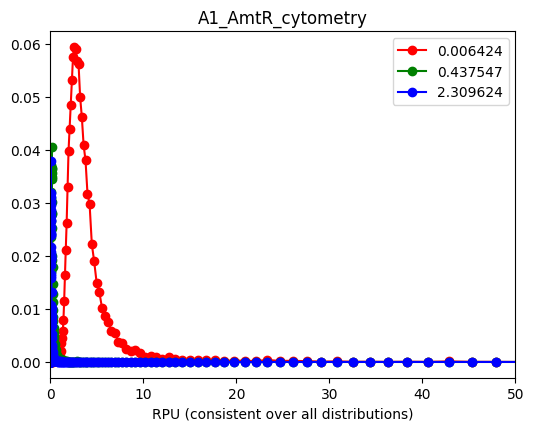

In [241]:
gate_cytometry_name = f"{gate_name}_cytometry"
gate_cytometry = [f for f in functions_lib if f["name"] == gate_cytometry_name][0]

pprint(gate_cytometry)

name = gate_cytometry['name']
measurements = gate_cytometry['table']

plt.figure(figsize=figsize)
plt.title(name)
plt.xlabel('RPU (consistent over all distributions)')

# Show some distributions
d = measurements[0]
plt.plot(d['bin'], d['output'], 'ro-', label=d['x'])

middle = int( len(measurements) / 2 )
d = measurements[middle]
plt.plot(d['bin'], d['output'], 'go-', label=d['x'])

d = measurements[-1]
plt.plot(d['bin'], d['output'], 'bo-', label=d['x'])

ax = plt.gca()
ax.set_xlim([0,50])
plt.legend()

# Let's check if the last one was really a distribution
print(f"Checking if distribution. This should be 1: {sum(d['output'])}")

## Model based on experimental data

To simplify this undertaking, we only model the expected input-output behavior.

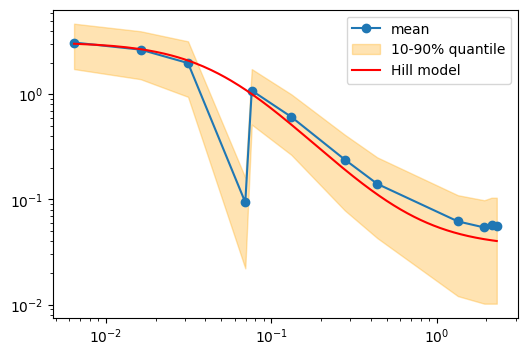

In [242]:
from scipy.stats import rv_discrete

x_vals = []
means = []
q10 = []
q90 = []

for d in measurements:
    x = d['x']
    vals = np.array(d['bin'], dtype=float)
    probs = np.array(d['output'], dtype=float)
    
    # Normalize probabilities
    probs = probs / probs.sum()
    
    # Create a discrete random variable
    dist = rv_discrete(values=(vals, probs))
    
    # Compute mean and quantiles
    mean = dist.mean()
    q10_val = dist.ppf(0.1)
    q90_val = dist.ppf(0.9)
    
    x_vals.append(x)
    means.append(mean)
    q10.append(q10_val)
    q90.append(q90_val)


x_vals = np.array(x_vals)
means = np.array(means)
q10 = np.array(q10)
q90 = np.array(q90)

# Get sorting indices
sort_idx = np.argsort(x_vals)

# Apply sorting to all arrays
x_vals = x_vals[sort_idx]
means = means[sort_idx]
q10 = q10[sort_idx]
q90 = q90[sort_idx]


plt.figure(figsize=(6,4))

# Plot mean as a line
plt.plot(x_vals, means, marker='o', label='mean')

# Fill between 10% and 90% quantiles
plt.fill_between(x_vals, q10, q90, color='orange', alpha=0.3, label='10-90% quantile')

# Set log-log scale
plt.xscale('log')
plt.yscale('log')

# also add the deterministic Hill approximation
x = np.linspace(x_vals[0], x_vals[-1], 1000)
plt.plot(x, inv(x), 'red', label = 'Hill model')

plt.legend()

# Problem 2: Gate characteristics

Plot all deterministic Hill models for all `NOR` gates in log-log plots.
You can plot them for a single combined input as we did.

The plot should be nicely arranged so that the viewer can compare them next to each other.
For example in a grid.
Also think about common axis limits, gate names as titles, etc.

What do you observe for the gate library. What does this mean for composition of gates?

# Problem 3: Simulation of Inverter Chain

Propagate determinsitic input-output values from inputs to an output.
Write a function that allows you to call `progagate(circuit: list[str], i: float) -> float`.
Here, `circuit` is a linear circuit of `NOR` gates but with a single input (`INV` gates).
The circuit is encoded as a `list[str]` of `NOR` names from the library.
Argument `i` is an input value in RPUs.

The output of the function is the output of the circuit in RPUs.


---
**License**: © 2025 Matthias Függer and Thomas Nowak. Licensed under [CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/).